In [1]:
from chirho_diffeqpy import DiffEqPy, ATempParams, PureDynamics
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import simulate
from chirho.dynamical.handlers.trajectory import LogTrajectory
from chirho.dynamical.handlers import StaticBatchObservation, StaticIntervention, DynamicIntervention
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.observational.handlers import condition
from chirho.dynamical.ops import State
import numpy as np
import torch
from pyro import sample, set_rng_seed
from pyro.distributions import Uniform, Poisson
from typing import Tuple, Optional, Union, Callable
from functools import partial
from numbers import Real
import matplotlib.pyplot as plt
from typing import List
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta, AutoMultivariateNormal, AutoDiagonalNormal
from contextlib import nullcontext
# The DiffEqPy backend interfaces with julia, so we must load a julia<>python interop backend.
import chirho_diffeqpy.lang_interop.julianumpy
from contextlib import ExitStack, nullcontext
from pyro.contrib.autoname import scope
# Global params are weird.
from functools import singledispatch, partial
import pyro
import torch
import zuko
from pyro.contrib.zuko import ZukoToPyro
from pyro.contrib.easyguide import easy_guide
from collections import namedtuple
from chirho.observational.handlers import condition
from chirho.observational.handlers.predictive import PredictiveModel

pyro.settings.set(module_local_params=True)
torch.set_default_dtype(torch.float64)
pyro.set_rng_seed(623730)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating project at `~/.julia/environments/diffeqpy`
  Activating project at `~/.julia/environments/diffeqpy`
  Activating project at `~/.julia/environments/diffeqpy`
  Activating project at `~/.julia/environments/diffeqpy`


In [2]:
def sinusoid_dynamics(state: State, atemp_params: ATempParams):
    frequency = atemp_params['frequency']
    amplitude = atemp_params['amplitude']
    decay = atemp_params['decay']
    t = state['t']
    
    return dict(
        # The time derivative of a sin wave, plus a decay term.
        y=amplitude * frequency * np.cos(frequency * t) - decay*state['y']
    )

SOLVER = DiffEqPy()

In [3]:
def sinusoid_param_prior():
    return dict(
        frequency=sample("frequency", dist.Uniform(0.1, torch.pi)),
        amplitude=sample("amplitude", dist.Uniform(0.1, 2.0)),
        decay=sample("decay", dist.Uniform(0.01, 1.0))
    )


def add_observation_noise(state):
    y = state['y']
    return dict(
        y=sample("obs_y", dist.Normal(y, 0.1).to_event(1))
    )

def observation_noise_model(state) -> None:
    # The StaticBatchObservation obs function needs to return None.
    add_observation_noise(state)

In [4]:
def stochastic_jump_model(num_jumps: int, start_time: torch.Tensor, end_time: torch.Tensor, noise_per_time_unit: float):
   
    # <Dynamics>
    initial_state = dict(
        # y=sample("y0", dist.Normal(0.0, 1.0)),
        y=torch.tensor(3.0)
    )
    
    sinusoid_params = sinusoid_param_prior()
    # </Dynamics>
    
    # <Jump Model>
    with pyro.plate("jumps", num_jumps):
        jump_times = sample("jump_times", Uniform(start_time, end_time))
    
        # Compute the noise prior. I'm not really sure how this should be handled, but the idea
        #  is to make it kinda brownian, where noise is proportional to the average distance between
        #  jumps.
        total_time = end_time - start_time
        total_noise = noise_per_time_unit * total_time
        noise_per_jump = total_noise / num_jumps
        # In this case I'm just saying that the noise can't be larger than the brownian assumption would allow.
        # Maybe `max_noise_per_time_unit` and `max_noise_per_jump` would be appropriate.
        # I think bounding it this way would require the jump times to space themselves out more or less evenly?
        noises = sample("noises", dist.Uniform(0.001, noise_per_jump))
    
    def jump_intervention_fn(val: torch.Tensor, jump_idx: int, noise: torch.Tensor):
        return sample(f"jump{jump_idx}", dist.Normal(val, noise))
    
    jump_interventions = ExitStack()
    for i, (jump_time, noise) in enumerate(zip(jump_times, noises)):
        jump_intervention = StaticIntervention(
            time=jump_time,
            intervention=dict(y=partial(jump_intervention_fn, jump_idx=i, noise=noise))
        )
        jump_interventions.enter_context(jump_intervention)
    
    with jump_interventions:
        simulate(
            sinusoid_dynamics,
            initial_state,
            start_time,
            end_time,
            atemp_params=sinusoid_params,
        )
    # </Jump Model>
    
    return jump_times

In [5]:
START_T = 0.0
END_T = 15.0
NOISE_PER_TIME_UNIT = 5.0
NUM_JUMPS = 1000
RES = 10000
TRUE_COEFS = dict(
    frequency=torch.tensor(1.0),
    amplitude=torch.tensor(1.0),
    decay=torch.tensor(0.3)
)

with SOLVER, LogTrajectory(times=torch.linspace(START_T, END_T, RES)) as lt, condition(data=TRUE_COEFS):
    jump_times = stochastic_jump_model(NUM_JUMPS, torch.tensor(START_T), torch.tensor(END_T), NOISE_PER_TIME_UNIT)
data = add_observation_noise(lt.trajectory)

In [6]:
def plot_trajectory(lt: LogTrajectory, data: dict, jump_times: List[torch.Tensor], data_times: Optional = None, jump_lw=0.01):
    plt.figure()
    plt.plot(data_times if data_times is not None else lt.times, data['y'].detach(), linewidth=0.1)
    plt.plot(lt.times, lt.trajectory['y'].detach(), alpha=1.0, linewidth=1.0)
    for jump_time in jump_times:
        plt.axvline(jump_time.item(), color='red', linestyle='--', linewidth=jump_lw)

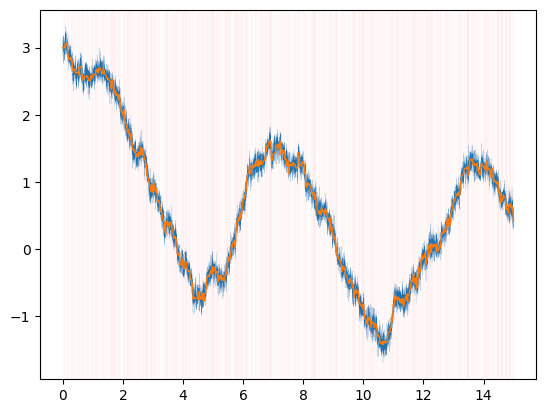

In [7]:
plot_trajectory(lt, data, jump_times)

In [8]:
data_sub = {k: v[::20] for k, v in data.items()}
time_sub = lt.times[::20]
print(time_sub.shape)
print({k: v.shape for k, v in data_sub.items()})

torch.Size([500])
{'y': torch.Size([500])}


In [9]:
partial_jump_model = partial(
    stochastic_jump_model,
    # Using far fewer jumps than before. The goal is to see where these jumps land and if a single jump can account
    #  for a large set of jumps in the original data generating process.
    num_jumps=10,
    start_time=torch.tensor(START_T),
    end_time=torch.tensor(END_T),
    noise_per_time_unit=NOISE_PER_TIME_UNIT
)

def conditioned_model():
    with SOLVER, StaticBatchObservation(times=time_sub, observation=condition(data=data_sub)(observation_noise_model)):
        partial_jump_model()

In [10]:
SVI = namedtuple('SVI', ['step', 'guide', 'losses'])

def build_svi(model, *args, **kwargs):
    # guide = AutoDelta(model)
    guide = AutoDiagonalNormal(model)
    # guide = AutoMultivariateNormal(model)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    elbo()  # initialize parameters.
    optim = torch.optim.Adam(elbo.parameters(), lr=3e-3)
    losses = []
    
    def step():
        optim.zero_grad()
        loss = elbo()
        loss.backward()
        optim.step()
        
        losses.append(loss.detach().item())
    
    return SVI(step, guide, losses)

In [11]:
svi = build_svi(conditioned_model)

In [20]:
NITER = 2000
for i in range(NITER):
    svi.step()
    print(f"Progress {i}/{NITER}", end='\r')

Text(0.5, 0.98, 'ELBO Loss')

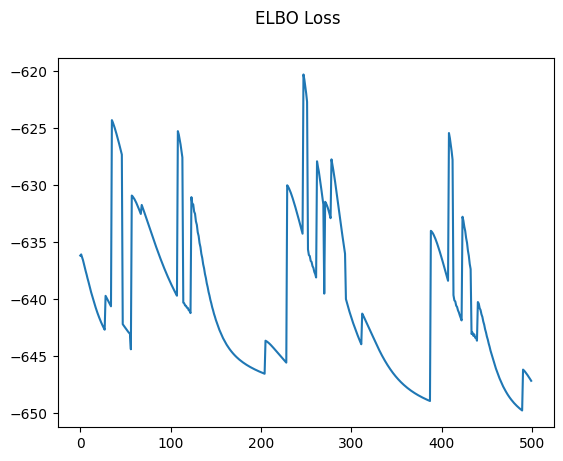

In [21]:
plt.figure()
plt.plot(svi.losses[-500:])
plt.suptitle("ELBO Loss")

In [22]:
def logged_model():
    with SOLVER, LogTrajectory(times=torch.linspace(START_T, END_T, RES)) as lt:
        return partial_jump_model(), lt

predictive_model = PredictiveModel(logged_model, svi.guide)

In [23]:
jump_times_learned, lt_learned = predictive_model()

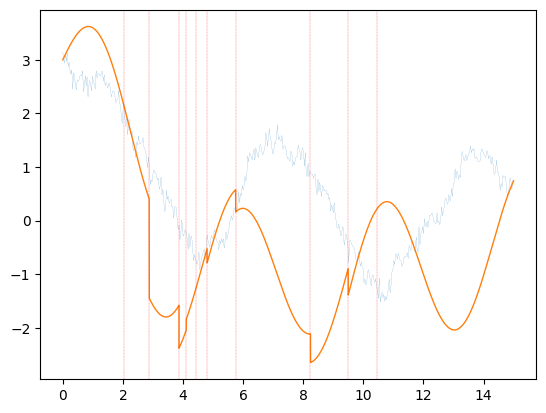

In [24]:
plot_trajectory(lt_learned, data_sub, jump_times_learned, data_times=time_sub, jump_lw=0.2)

In [25]:
print(
    f"Frequency: True={TRUE_COEFS['frequency']}, Learned={predictive_model.guide()['frequency']}",
    f"Amplitude: True={TRUE_COEFS['amplitude']}, Learned={predictive_model.guide()['amplitude']}",
    f"Decay: True={TRUE_COEFS['decay']}, Learned={predictive_model.guide()['decay']}",
)

Frequency: True=1.0, Learned=1.3070643205837384 Amplitude: True=1.0, Learned=1.4407533398776913 Decay: True=0.3, Learned=0.23159240559478347
